#Toric Code on Quntum Computer

In [ ]:
!pip install pennylane

# Introduction

The *toric code model* is a treasure trove of interesting physics and
mathematics. The model sparked the development of the error-correcting
surface codes, an essential category of error correction models. But why
is the model so useful for error correction?

We delve into mathematics and condensed matter physics to answer that
very question. Viewing the model as a description of spins in an exotic
magnet allows us to start analyzing the model as a material. What kind
of material is it? The toric code is an example of a topological state
of matter.

A state of matter, or phase, cannot become a different phase without
some discontinuity in the physical properties as coefficients in the
Hamiltonian change. This discontinuity may exist in an arbitrary order
derivative or non-local observable. For example, ice cannot become water
without a discontinuity in density as the temperature changes. The
ground state of a **topological** state of matter cannot smoothly deform
to a non-entangled state without a phase transition. Entanglement, and
more critically *long-range* entanglement, is a key hallmark of a
topological state of matter.

Local measurements cannot detect topological states of matter. We have
to consider the entire system to determine a topological phase. To
better consider this type of property, consider the parity of the number
of dancers on a dance floor. Does everyone have a partner, or is there
an odd person out? To measure that, we have to look at the entire
system.

Topology is the study of global properties that are preserved under
continuous deformations. For example, a coffee cup is equivalent to a
donut because they both have a single hole. More technically, they both
have an [Euler
characteristic](https://en.wikipedia.org/wiki/Euler_characteristic) of
zero. When we zoom to a local patch, both a sphere and a torus look the
same. Only by considering the object as a whole can you detect the
single hole.

<figure>
<img src="../_static/demonstration_assets/toric_code/torus_to_cup.png"
class="align-center" style="width:70.0%"
alt="../_static/demonstration_assets/toric_code/torus_to_cup.png" />
<figcaption>A donut can be smoothly deformed into a mug.</figcaption>
</figure>

In this demo, we will look at the degenerate ground state and the
excitations of the toric code model. The toric code was initially
proposed in "Fault-tolerant quantum computation by anyons" by Kitaev.
This demo was inspired by "Realizing topologically ordered states on a
quantum processor" by K. J. Satzinger et al. For further reading, I
recommend "Quantum Spin Liquids" by Lucile Savary and Leon Balents and
\"A Pedagogical Overview on 2D and 3D Toric Codes and the Origin of
their Topological Orders\".

# The Model

What is the source of all this fascinating physics? The Hamiltonian is:

$$\mathcal{H} = -\sum_s S_s - \sum_p P_p,$$

where

$$S_s = \prod_{i \in s} Z_i \quad P_p = \prod_{j \in p} X_j.$$

In the literature, the $S_s$ terms are called the "star" operators, and
the $P_p$ terms are called the "plaquette" operators. Each star $s$ and
plaquette $p$ is a group of 4 sites on a square lattice. You can compare
this model to something like the [Heisenberg
model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model) used to
describe spins interacting magnetically in a material.

In the most common formulation of the model, sites live on the edges of
a square lattice. In this formulation, the "plaquette" operators are
products of Pauli X operators on all the sites in a square, and the
\"star\" operators are products of Pauli Z operators on all the sites
bordering a vertex.

Instead, we can view the model as a checkerboard of alternating square
types. In this formulation, all sites $i$ and $j$ are the vertices of a
square lattice. Each square is a group of four sites, and adjacent
squares alternate between the two types of groups. Since the groups on
this checkerboard no longer look like stars and plaquettes, we will call
them the "Z Group" and "X Group" operators in this tutorial.

<figure>
<img
src="../_static/demonstration_assets/toric_code/stars_plaquettes2.png"
class="align-center" style="width:70.0%"
alt="../_static/demonstration_assets/toric_code/stars_plaquettes2.png" />
<figcaption>On the left, sites are grouped into stars around vertices
and plaquettes on the faces. On the right, we view the lattice as a
checkerboard of alternating types of groups.</figcaption>
</figure>

We will be embedding the lattice on a torus via periodic boundary
conditions. Periodic boundary conditions basically "glue" the bottom of
the lattice to the top of the lattice and the left to the right.

Modular arithmetic accomplishes this matching. Any site at `(x,y)` is
the same as a site at `(x+width, y+height)`.

<figure>
<img
src="../_static/demonstration_assets/toric_code/converting_to_torus.png"
class="align-center" style="width:70.0%"
alt="../_static/demonstration_assets/toric_code/converting_to_torus.png" />
<figcaption>By matching up the edges with periodic boundary conditions,
we turn a square grid into a torus.</figcaption>
</figure>


On to some practical coding! First, let\'s define the sites on a
$4\times 6$ lattice.

In [ ]:
import pennylane as qml
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Patch
from itertools import product
from dataclasses import dataclass

import numpy as np

np.set_printoptions(suppress=True)

height = 4
width = 6

all_sites = [(i, j) for i, j in product(range(width), range(height))]

We would like for our wire labels to match the sites. To do this, we
will be using an [Immutable Data
Class](https://realpython.com/python-data-classes/#immutable-data-classes)
. PennyLane allows wire labels to be any **hashable** object, but
iterable wire labels are currently not supported. Therefore we use a
frozen dataclass to represent individual wires by a row and column
position.

In [ ]:
@dataclass(frozen=True)
class Wire:
    i: int
    j: int

example_wire = Wire(1, 4)
print("Example wire: ", example_wire)
print("At coordinates: ", example_wire.i, example_wire.j)

Example wire:  Wire(i=1, j=4)
At coordinates:  1 4


# Setting up Operators

For each type of group operator (X and Z), we will have two different
lists: the "sites" and the "ops". The "sites" are tuples and will
include virtual sites off the edge of the lattice that match up with
locations on the other side. We will use the `zgroup_sites` and `xgroup_sites`
lists to help us view the measurements of the corresponding operators.

The \"ops\" list will contain the tensor observables. We will later take
the expectation value of each tensor.

In [ ]:
mod = lambda s: Wire(s[0] % width, s[1] % height)

zgroup_sites = []  # list of sites in each group
zgroup_ops = []  # list of operators for each group

for x, y in product(range(width // 2), range(height)):

    x0 = 2 * x + (y + 1) % 2 # x starting coordinate

    sites = [(x0, y), (x0 + 1, y), (x0 + 1, y + 1), (x0, y + 1)]

    op = qml.prod(*(qml.PauliZ(mod(s)) for s in sites))

    zgroup_sites.append(sites)
    zgroup_ops.append(op)

print("First set of sites: ", zgroup_sites[3])
print("First operator: ", zgroup_ops[3])

First set of sites:  [(0, 3), (1, 3), (1, 4), (0, 4)]
First operator:  Z(Wire(i=0, j=3)) @ Z(Wire(i=1, j=3)) @ Z(Wire(i=1, j=0)) @ Z(Wire(i=0, j=0))


In [ ]:
xgroup_sites = []
xgroup_ops = []
for x, y in product(range(width // 2), range(height)):
    x0 = 2 * x + y % 2 # lower x coordinate

    sites = [(x0 + 1, y + 1), (x0, y + 1), (x0, y), (x0 + 1, y)]

    if x == 2 and y == 1:  # change order for state prep later
        sites = sites[1:] + sites[0:1]

    op = qml.prod(*(qml.PauliX(mod(s)) for s in sites))

    xgroup_sites.append(sites)
    xgroup_ops.append(op)

print("First set of sites: ", xgroup_sites[1])
print("First operator: ", xgroup_ops[1])

First set of sites:  [(2, 2), (1, 2), (1, 1), (2, 1)]
First operator:  X(Wire(i=2, j=2)) @ X(Wire(i=1, j=2)) @ X(Wire(i=1, j=1)) @ X(Wire(i=2, j=1))


How can we best visualize these groups of four sites?
The dotted horizontal lines and dashed vertical lines denote
where we glue our boundaries together.

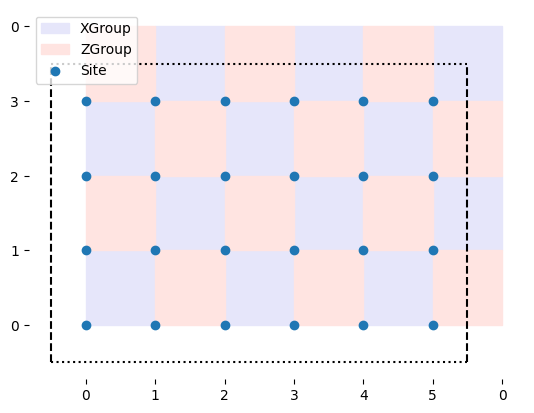

In [ ]:
def misc_plot_formatting(fig, ax):
    plt.hlines([-0.5, height - 0.5], -0.5, width - 0.5, linestyle="dotted", color="black")
    plt.vlines([-0.5, width - 0.5], -0.5, height - 0.5, linestyle="dashed", color="black")
    plt.xticks(range(width + 1), [str(i % width) for i in range(width + 1)])
    plt.yticks(range(height + 1), [str(i % height) for i in range(height + 1)])

    for direction in ["top", "right", "bottom", "left"]:
        ax.spines[direction].set_visible(False)

    return fig, ax


fig, ax = plt.subplots()
fig, ax = misc_plot_formatting(fig, ax)

for group in xgroup_sites:
    x_patch = ax.add_patch(Polygon(group, color="lavender", zorder=0))

for group in zgroup_sites:
    z_patch = ax.add_patch(Polygon(group, color="mistyrose", zorder=0))

plt_sites = ax.scatter(*zip(*all_sites))

plt.legend([x_patch, z_patch, plt_sites], ["XGroup", "ZGroup", "Site"], loc="upper left")

plt.show()

# The Ground State

While individual X and Z operators do not commute with each other, the X
Group and Z Group operators do:

$$[S_s, P_p] = 0.$$

Since they commute, the wavefunction can be an eigenstate of each group
operator independently. To minimize the energy of the Hamiltonian on the
system as a whole, we can minimize the contribution of each group
operator. Due to the negative coefficients in the Hamiltonian, we need
to maximize the expectation value of each operator. The maximum possible
expectation value for each operator is $+1.$ We can turn this into a
constraint on our ground state:

$$S_s |G \rangle = +1 |G \rangle \qquad \qquad P_p | G \rangle = +1 |G\rangle.$$

The wavefunction

$$| G \rangle =  \prod_{p} \frac{\mathbb{I} + P_p}{\sqrt{2}} |00\dots 0\rangle = \prod_{p} U_p |00\dots 0 \rangle,$$

where $P_p$ (plaquette) denotes an X Group operator, is such a state.

$|G \rangle$ contains a product of unitaries $U_p.$ If we can figure out
how to apply a single $U_p$ using a quantum computer\'s operations, we
can apply that decomposition for every $p$ in the product.

To better understand how to decompose $U_p,$ let's write it concretely
for a single group of four qubits:

$$U |0000 \rangle =
\frac{\left(\mathbb{I} + X_1 X_2 X_3 X_4 \right)}{\sqrt{2}} |0000 \rangle
= \frac{1}{\sqrt{2}} \left( |0000\rangle + |1111\rangle \right).$$

This [generalized GHZ
state](https://en.wikipedia.org/wiki/Greenberger–Horne–Zeilinger_state)
can be prepared with a Hadamard and 3 CNOT gates:

![](../_static/demonstration_assets/toric_code/generalized_ghz_draw.png){.align-center
width="50.0%"}

This decomposition for $U_p$ holds only when the initial Hadamard qubit
begins in the $|0\rangle$ state, so we need to be careful in the choice
of the Hadamard\'s qubit. This restriction is why we rotated the order
for a single X Group on the right border earlier.

We will also not need to prepare the final X Group that contains the
four edges of the lattice.

Now let's actually put these together into a circuit!

In [ ]:
dev = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites])

def state_prep():
    for op in xgroup_ops[0:-1]:
        qml.Hadamard(op.wires[0])
        for w in op.wires[1:]:
            qml.CNOT(wires=[op.wires[0], w])

@qml.qnode(dev, diff_method=None)
def circuit():
    state_prep()
    return [qml.expval(op) for op in xgroup_ops + zgroup_ops]

From this QNode, we can calculate the group operators\' expectation
values and the system\'s total energy.

In [ ]:
n_xgroups = len(xgroup_ops)
separate_expvals = lambda expvals: (expvals[:n_xgroups], expvals[n_xgroups:])

xgroup_expvals, zgroup_expvals = separate_expvals(circuit())

E0 = -sum(xgroup_expvals) - sum(zgroup_expvals)

print("X Group expectation values", [np.round(val) for val in xgroup_expvals])
print("Z Group expectation values", [np.round(val) for val in zgroup_expvals])
print("Total energy: ", E0)

X Group expectation values [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Z Group expectation values [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Total energy:  -23.999999999999996


# Excitations

Quasiparticles allow physicists to describe complex systems as
interacting particles in a vacuum. Examples of quasiparticles include
electrons and holes in semiconductors, phonons, and magnons.

Imagine trying to describe the traffic on the road. We could either
explicitly enumerate the location of each vehicle or list the positions
and severities of traffic jams.

The first option provides complete information about the system but is
much more challenging to analyze. For most purposes, we can work with
information about how the traffic deviates from a baseline. In
semiconductors, we don't write out the wave function for every single
electron. We instead use electrons and holes. Neither quasiparticle
electrons nor holes are fundamental particles like an electron or
positron in a vacuum. Instead, they are useful descriptions of how the
wave function differs from its ground state.

While the electrons and holes of a metal behave just like electrons and
positrons in a vacuum, some condensed matter systems contain
quasiparticles that cannot or do not exist as fundamental particles. The
excitations of the toric code are one such example. To find these
quasiparticles, we look at states that are *almost* the ground state,
such as the ground state with a single operator applied to it.

Suppose we apply a perturbation to the ground state in the form of a
single X gate at location $i$ :

$$| \phi \rangle = X_i | G \rangle.$$

Two Z group operators $S_s$ contain individual Z operators at that same
site $i.$ The noise term $X_i$ will anti-commute with both of these
group operators:

$$S_s X_i = \left( Z_i Z_a Z_b Z_c \right) X_i = - X_i S_s.$$

Using this relation, we can determine the expectation value of the Z
group operators with the altered state:

$$S_s |\phi\rangle = S_s X_i |G\rangle = - X_i S_s |G\rangle = - X_i |G\rangle = - |\phi\rangle.$$

Thus,

$$\langle \phi | S_s | \phi \rangle = -1.$$

$S_s$ now has an expectation value of $-1.$

Applying a single X operator noise term changes the expectation value of
*two* Z group operators.

This analysis repeats for the effect of a Z operator on the X Group
measurement. A single Z operator noise term changes the expectation
values of *two* X group operators.

Each group with a negative expectation value is considered an
excitation. In the literature, you will often see a Z Group excitation
$\langle S_s \rangle = -1$ called an "electric" $e$ excitation and an X
Group excitation $\langle P_p \rangle = -1$ called a "magnetic" $m$
excitation. You may also see the inclusion of an identity $\mathbb{I}$
particle for the ground state and the combination particle $\Psi$
consisting of a single $e$ and a single $m$ excitation.

Let's create a QNode where we can apply these perturbations:

In [ ]:
@qml.qnode(dev, diff_method=None)
def excitations(x_sites, z_sites):
    state_prep()

    for s in x_sites:
        qml.PauliX(Wire(*s))

    for s in z_sites:
        qml.PauliZ(Wire(*s))

    return [qml.expval(op) for op in xgroup_ops + zgroup_ops]

What are the expectation values when we apply a single X operation? Two
Z group measurements have indeed changed signs.

In [ ]:
single_x = [(1, 2)]

x_expvals, z_expvals = separate_expvals(excitations(single_x, []))

print("XGroup: ", [np.round(val) for val in x_expvals])
print("ZGroup: ", [np.round(val) for val in z_expvals])

XGroup:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ZGroup:  [1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Instead of interpreting the state via the expectation values of the
operators, we can view the state as occupation numbers of the
corresponding quasiparticles. A group with an expectation value of $+1$
is in the ground state and thus has an occupation number of $0.$ If the
expectation value is $-1,$ then a quasiparticle exists in that location.


In [ ]:
occupation_numbers = lambda expvals: [0.5 * (1 - np.round(val)) for val in expvals]

def print_info(x_expvals, z_expvals):
    E = -sum(x_expvals) - sum(z_expvals)

    print("Total energy: ", E)
    print("Energy above the ground state: ", E - E0)
    print("X Group occupation numbers: ", occupation_numbers(x_expvals))
    print("Z Group occupation numbers: ", occupation_numbers(z_expvals))

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Since we will plot the same thing many times, we group the following
code into a function to easily call later.

In [ ]:
def excitation_plot(x_excite, z_excite):
    x_color = lambda expval: "navy" if expval < 0 else "lavender"
    z_color = lambda expval: "maroon" if expval < 0 else "mistyrose"

    fig, ax = plt.subplots()
    fig, ax = misc_plot_formatting(fig, ax)

    for expval, sites in zip(x_excite, xgroup_sites):
        ax.add_patch(Polygon(sites, color=x_color(expval), zorder=0))

    for expval, sites in zip(z_excite, zgroup_sites):
        ax.add_patch(Polygon(sites, color=z_color(expval), zorder=0))

    handles = [
        Patch(color="navy", label="X Group -1"),
        Patch(color="lavender", label="X Group +1"),
        Patch(color="maroon", label="Z Group -1"),
        Patch(color="mistyrose", label="Z Group +1"),
        Patch(color="navy", label="Z op"),
        Patch(color="maroon", label="X op"),
    ]

    plt.legend(handles=handles, ncol=3, loc="lower left")

    return fig, ax

With this function, we can quickly view the expectation values and the
location of the additional X operation. The operation changes the
expectation values for the adjacent Z groups.


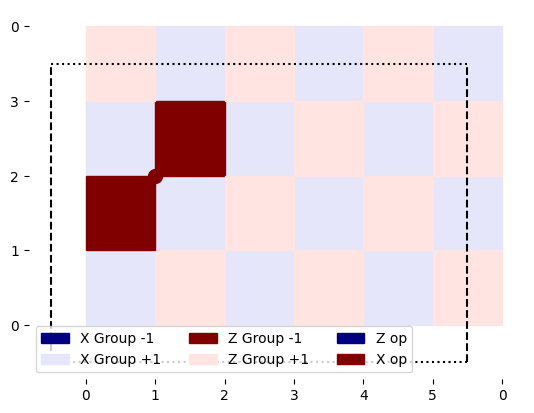

In [ ]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_x), color="maroon", s=100)
plt.show()

What if we apply a Z operation instead at the same site? We instead get
two X Group excitations.

In [ ]:
single_z = [(1, 2)]

expvals = excitations([], single_z)
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


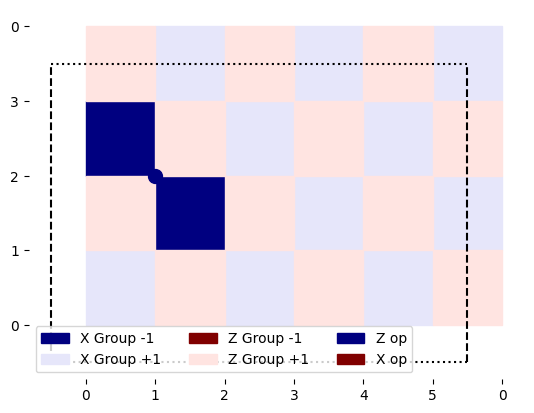

In [ ]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.scatter(*zip(*single_z), color="navy", s=100)
plt.show()

What happens if we apply the same perturbation twice at one location? We
regain the ground state.

The excitations of the toric code are Majorana particles: particles that
are their own antiparticles. While postulated to exist in standard
particle physics, Majorana particles have only been experimentally seen
as quasiparticle excitations in materials.

We can think of the second operation as creating another set of
excitations at the same location. This second pair then annihilates the
existing particles.


In [ ]:
single_z = [(1, 2)]

expvals = excitations([], single_z + single_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Moving Excitations and String Operators

What if we create a second set of particles such that one of the new
particles overlaps with an existing particle? One old and one new
particle annihilate each other. One old and one new particle remain. We
still have two particles in total.

Alternatively, we can view the second operation as moving a single
excitation.

Let's see what that looks like in code:


In [ ]:
two_z = [(1, 2), (2, 2)]

expvals = excitations([], two_z)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


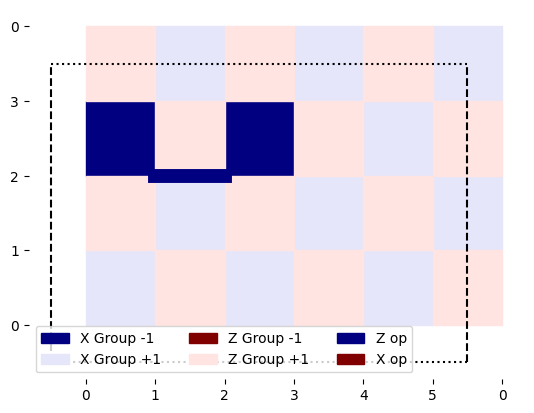

In [ ]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*two_z), color="navy", linewidth=10)
plt.show()

In that example, we just moved an excitation a little. How about we try
moving it even further?


In [ ]:
long_string = [(1, 2), (2, 2), (3, 2), (4, 1)]

expvals = excitations([], long_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


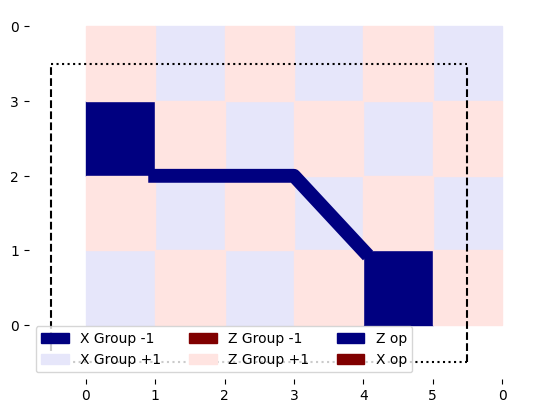

In [ ]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*long_string), color="navy", linewidth=10)
plt.show()

We end up with strings of operations that connect pairs of
quasiparticles.

We can use a branch of topology called
[Homotopy](https://en.wikipedia.org/wiki/Homotopy) to describe the
relationship between these strings and the wave function. Two paths
$s_1$ and $s_2$ are **homotopy equivalent** or **homotopic** if they can
be continuously deformed into each other:

$$s_1 \sim s_2$$

In the following picture, assume the red "X" is a defect in space, like
a tear in a sheet. The two blue paths are equivalent because you can
smoothly move one into the other. You cannot move the blue path into the
green path without going through the defect, so they are not equivalent
to each other.

<figure>
<img src="../_static/demonstration_assets/toric_code/homotopy.png"
class="align-center" style="width:40.0%"
alt="../_static/demonstration_assets/toric_code/homotopy.png" />
<figcaption>Paths are homotopy equivalent if they can be smoothly
deformed into each other.</figcaption>
</figure>

We can divide the set of all possible paths into **homotopy classes**. A
homotopy class is an [equivalence
class](https://en.wikipedia.org/wiki/Equivalence_class) under homotopy.
Every member of the same homotopy class can be deformed into every other
member of the same class, and members of different homotopy classes
cannot be deformed into each other. All the homotopy classes for a given
space $S$ form its [first homotopy
group](https://en.wikipedia.org/wiki/Homotopy_group), denoted by
$\pi_1(S).$ The first homotopy group of a space is also called its
*fundamental group*.

How do these mathematical concepts apply to the toric code model? To
find out, let\'s look at a string of Z operations homotopic to the one
above.

This next string creates the same final state. Only the homotopy class
of the path used to create the excitations influences the occupation
numbers and total energy. If the endpoints are the same and the path
doesn't wrap around the torus or other particles, the details do not
impact any observables.

In [ ]:
equivalent_string = [(1, 2), (2, 1), (3, 1), (4, 1)]

expvals = excitations([], equivalent_string)
x_expvals, z_expvals = separate_expvals(expvals)

print_info(x_expvals, z_expvals)

Total energy:  -19.999999999999996
Energy above the ground state:  4.0
X Group occupation numbers:  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


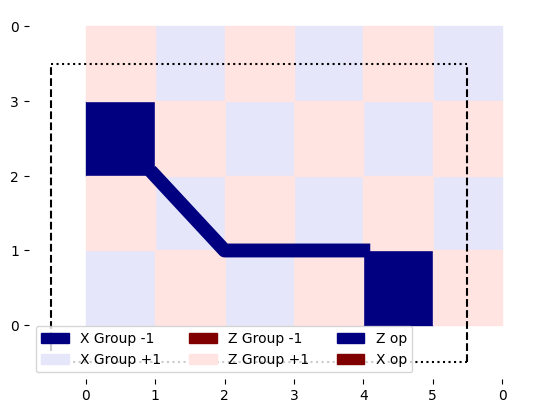

In [ ]:
fig, ax = excitation_plot(x_expvals, z_expvals)
ax.plot(*zip(*equivalent_string), color="navy", linewidth=10)
plt.show()

# Contractible loops

We can also have a loop of operations that doesn't create any new
excitations. The loop forms a pair, moves one around in a circle, and
then annihilates the two particles again.


In [ ]:
contractible_loop = [(1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (3, 3), (2, 3), (1, 2)]

expvals = excitations(contractible_loop, [])
x_expvals, z_expvals = separate_expvals(expvals)
print_info(x_expvals, z_expvals)

Total energy:  -23.999999999999996
Energy above the ground state:  0.0
X Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Z Group occupation numbers:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


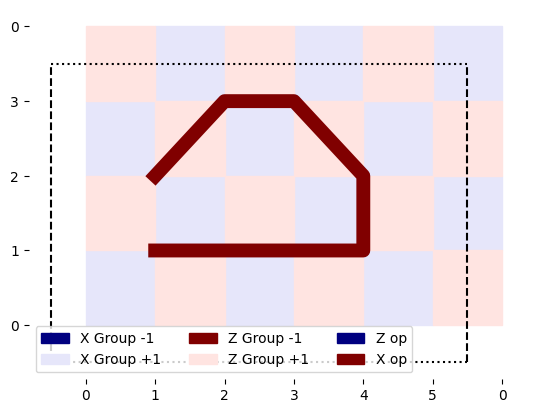

In [ ]:
fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*contractible_loop), color="maroon", linewidth=10)

plt.show()

The loop doesn't affect the positions of any excitations, but does it
affect the state at all?

We will look at the probabilities instead of the expectation values to
answer that question.


In [ ]:
@qml.qnode(dev, diff_method=None)
def probs(x_sites, z_sites):
    state_prep()

    for s in x_sites:
        qml.PauliX(Wire(*s))

    for s in z_sites:
        qml.PauliZ(Wire(*s))

    return qml.probs(wires=[Wire(*s) for s in all_sites])


null_probs = probs([], [])
contractible_probs = probs(contractible_loop, [])

print("Are the probabilities equal? ", np.allclose(null_probs, contractible_probs))

Are the probabilities equal?  True


The toric code\'s dependence on the homotopy of the path explains this
result. All paths we can smoothly deform into each other will give the
same result. The contractible loop can be smoothly deformed to nothing,
so the state with the contractible loop is the same as the state with no
loop, our initial $|G\rangle.$


# Looping the torus

On the torus, we have four types of unique paths:

-   The trivial path that contracts to nothing
-   A horizontal loop around the boundaries
-   A vertical loop around the boundaries
-   A loop around both the horizontal and vertical boundaries

<figure>
<img src="../_static/demonstration_assets/toric_code/types_of_loops.png"
class="align-center" style="width:50.0%"
alt="../_static/demonstration_assets/toric_code/types_of_loops.png" />
<figcaption>The homotopy group of a torus can be generated by a
horizontal loop and a vertical loop around the boundaries.</figcaption>
</figure>

Each of these paths represents a member of the first homotopy group of
the torus: $\pi_1(T) = \mathbb{Z}^2$ modulo 2.

None of these loops of X operations create net excitations, so the wave
function remains in the ground state.

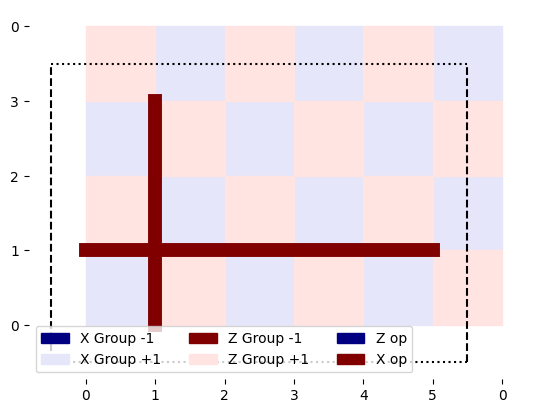

In [ ]:
horizontal_loop = [(i, 1) for i in range(width)]
vertical_loop = [(1, i) for i in range(height)]

expvals = excitations(horizontal_loop + vertical_loop, [])
fig, ax = excitation_plot(*separate_expvals(expvals))

ax.plot(*zip(*horizontal_loop), color="maroon", linewidth=10)
ax.plot(*zip(*vertical_loop), color="maroon", linewidth=10)

plt.show()

We can compute the probabilities for each of these four types of loops:


In [ ]:
null_probs = probs([], [])
horizontal_probs = probs(horizontal_loop, [])
vertical_probs = probs(vertical_loop, [])
combo_probs = probs(horizontal_loop + vertical_loop, [])

While X and Z operations can change the group operator expectation
values and create quasiparticles, only X operators can change the
probability distribution. Applying a Z operator would only rotate the
phase of the state and not change any amplitudes. Hence we only use
loops of X operators in this section. I encourage you to try this
analysis with loops of Z operators to confirm that they do not change
the probability distribution.

We can compare the original state and one with a horizontal loop to see
if the probability distributions are different:


In [ ]:
print("Are the probabilities equal? ", qml.math.allclose(null_probs, horizontal_probs))
print("Is this significant?")
print("Maximum difference in probabilities: ", max(abs(null_probs - horizontal_probs)))
print("Maximum probability: ", max(null_probs))

Are the probabilities equal?  False
Is this significant?
Maximum difference in probabilities:  0.00048828124999999913
Maximum probability:  0.00048828124999999913


These numbers seem small, but remember we have 24 qubits, and thus
$2^{24}=16777216$ probability components. Since the maximum difference
in probabilities is the same size as the maximum probability, we know
this isn't just random fluctuations and errors. The states are
different, but the energies are the same, so they are *degenerate*.

That compared a horizontal "x" loop with the initial ground state. How
about the other two types of loops? Let's iterate over all combinations
of two probability distributions to see if any match.


In [ ]:
probs_type_labels = ["null", "x", "y", "combo"]
all_probs = [null_probs, horizontal_probs, vertical_probs, combo_probs]

print("\t" + "\t".join(probs_type_labels))

for name, probs1 in zip(probs_type_labels, all_probs):
    comparisons = (str(np.allclose(probs1, probs2)) for probs2 in all_probs)
    print(name, "\t", "\t".join(comparisons))

	null	x	y	combo
null 	 True	False	False	False
x 	 False	True	False	False
y 	 False	False	True	False
combo 	 False	False	False	True


This table shows the model has four distinct ground states. More
importantly, these ground states are separated from each other by
long-range operations. We must perform a loop of operations across the
entire lattice to switch between degenerate ground states.

This four-way degeneracy is the source of the error correction in the
toric code. Instead of 24 qubits, we work with two logical qubits (4
states) that are well separated from each other by topological
operations.



I encourage dedicated readers to explore what happens when a path loops
the same boundaries twice.


In this section, we\'ve seen that the space of ground states is directly
related to the first homotopy group of the lattice. The first homotopy
group of a torus is $\pi_1(T) = \mathbb{Z}^2,$ and the space of ground
states is that group modulo two, $\mathbb{Z}_2^2.$

What if we defined the model on a differently shaped lattice? Then the
space of the ground state would change to reflect the first homotopy
group of that space. For example, if the model was defined on a sphere,
then only a single unique ground state would exist. Adding defects like
missing sites to the lattice also changes the topology. Error correction
with the toric code often uses missing sites to add additional logical
qubits.


# Mutual and Exchange Statistics

The hole in the center of the donut isn't the only thing that prevents
paths from smoothly deforming into each other. We don't yet know if we
can distort paths past other particles.

When one indistinguishable fermion of spin 1/2 orbits another fermion of
the same type, the combined wave function picks up a relative phase of
negative one. When fermions of different types orbit each other, the
state is unchanged. For example, if an electron goes around a proton and
returns to the same spot, the wave function is unchanged. If a boson
orbits around a different type of boson, again, the wave function is
unchanged.

What if a particle went around a different type of particle and
everything picked up a phase? Would it be a boson or a fermion?

It would be something else entirely: an anyon. An anyon is anything that
doesn't cleanly fall into the boson/fermion categorization of particles.

While the toric code is just an extremely useful mathematical model,
anyons exist in physical materials. For example, fractional quantum Hall
systems have anyonic particles with spin $1/q$ for different integers
$q.$

The **statistics** are described by the phase accumulated by moving one
particle around another. For example, if the particle picks up phases
like a fermion, then it obeys [Fermi-Dirac
statistics](https://en.wikipedia.org/wiki/Fermi–Dirac_statistics).
**Exchange statistics** are described by the phases that accumulate from
exchanging the *same* type of particles. **Mutual** statistics are
characterized by the phase acquired by moving one particle around a
particle of a *different* type.

To measure the mutual statistics of a Z Group excitation and an X group
excitation, we need to prepare at least one of each type of particle and
then orbit one around the other.

The following code rotates an X Group excitation around a Z Group
excitation.


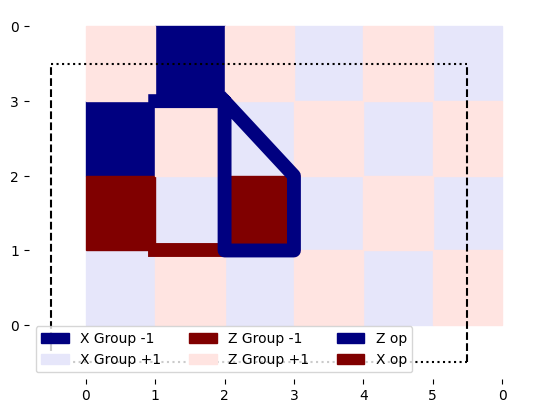

In [ ]:
prep1 = [(1, 1), (2, 1)]
prep2 = [(1, 3)]
loop1 = [(2, 3), (2, 2), (2, 1), (3, 1), (3, 2), (2, 3)]

expvals = excitations(prep1, prep2 + loop1)
x_expvals, z_expvals = separate_expvals(expvals)

fig, ax = excitation_plot(x_expvals, z_expvals)

ax.plot(*zip(*prep1), color="maroon", linewidth=10)
ax.plot(*zip(*(prep2 + loop1)), color="navy", linewidth=10)

plt.show()

While we managed to loop one particle around the other, we did not
extract the relative phase applied to the wave function. To procure this
information, we will need the *Hadamard test*.


# Hadamard test

The [Hadamard
test](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation))
extracts the real component of a unitary operation
$\text{Re}\left(\langle \psi | U | \psi \rangle \right).$ If the unitary
operation just applies a phase
$U |\psi\rangle = e^{i \phi} |\psi \rangle,$ the measured quantity
reduces to $\cos (\phi).$

The steps in the Hadamard test are:

1.  Prepare the auxiliary qubit into a superposition with a Hadamard
    gate
2.  Apply a controlled version of the operation with the auxiliary qubit
    as the control
3.  Apply another Hadamard gate to the auxiliary qubit
4.  Measure the auxiliary qubit in the Z-basis

![](../_static/demonstration_assets/toric_code/Hadamard_test.png){.align-center
width="50.0%"}


For extra understanding, validate the Hadamard test algorithm using pen
and paper.
:::

Below we implement this algorithm in PennyLane and measure the mutual
exchange statistics of an X Group excitation and a Z Group excitation.


In [ ]:
dev_aux = qml.device("lightning.qubit", wires=[Wire(*s) for s in all_sites] + ["aux"])

def loop(x_loop, z_loop):
    for s in x_loop:
        qml.PauliX(Wire(*s))
    for s in z_loop:
        qml.PauliZ(Wire(*s))

@qml.qnode(dev_aux, diff_method=None)
def hadamard_test(x_prep, z_prep, x_loop, z_loop):
    state_prep()

    for s in x_prep:
        qml.PauliX(Wire(*s))

    for s in z_prep:
        qml.PauliZ(Wire(*s))

    qml.Hadamard("aux")
    qml.ctrl(loop, control="aux")(x_loop, z_loop)
    qml.Hadamard("aux")
    return qml.expval(qml.PauliZ("aux"))

x_around_z = hadamard_test(prep1, prep2, [], loop1)
print("Move x excitation around z excitation: ", x_around_z)

Move x excitation around z excitation:  -0.9999999999999991


We just moved two different types of particles around each other and
picked up a phase. As neither bosons nor fermions behave like this, this
result demonstrates that the excitations of a toric code are anyons.

::: note
::: title
Note
:::

I encourage dedicated readers to calculate the phase accumulated by
exchanging:

-   A Z Group excitation and a Z Group Excitation
-   An X Group excitation and an X Group Excitation
-   A combination $\Psi$ particle and an X Group excitation
-   A combination $\Psi$ particle and a Z Group excitation
-   A combination $\Psi$ particle with another $\Psi$ particle

The combination particle should behave like a standard fermion. You can
create and move combination particles by applying `PauliY` operations.
:::

In this demo, we have demonstrated:

1.  How to prepare the ground state of the toric code model on a lattice
    of qubits
2.  How to create and move excitations
3.  The ground state degeneracy of the model on a toric lattice, arising
    from homotopically distinct loops of operations
4.  The excitations are anyons due to non-trivial mutual statistics Make
    sure to go and modify the code as suggested if you wish to gain more
    intuition.
